In [1]:
# Following:
# - https://cookbook.openai.com/examples/parse_pdf_docs_for_rag

In [2]:
!cd /research/rgs01/home/clusterHome/jpastr08/biohackathon/KIDS24-team12/vm_files/Jose

In [3]:
!which python
!which pip

~/.conda/envs/py310/bin/python
~/.conda/envs/py310/bin/pip


In [4]:
# in terminal within same conda env
# conda install -c conda-forge poppler

In [5]:
#%pip install pdf2image -q
#%pip install pdfminer -q
#%pip install pdfminer.six -q
#%pip install openai -q
#%pip install scikit-learn -q
#%pip install rich -q
#%pip install tqdm -q
#%pip install pandas -q

In [6]:
# Imports
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdfminer.high_level import extract_text
import base64
import io
import os
import concurrent.futures
from tqdm import tqdm
from openai import OpenAI
import re
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from rich import print
from ast import literal_eval

In [7]:
# File processing
def convert_doc_to_images(path):
    images = convert_from_path(path)
    return images

def extract_text_from_doc(path):
    text = extract_text(path)
    return text

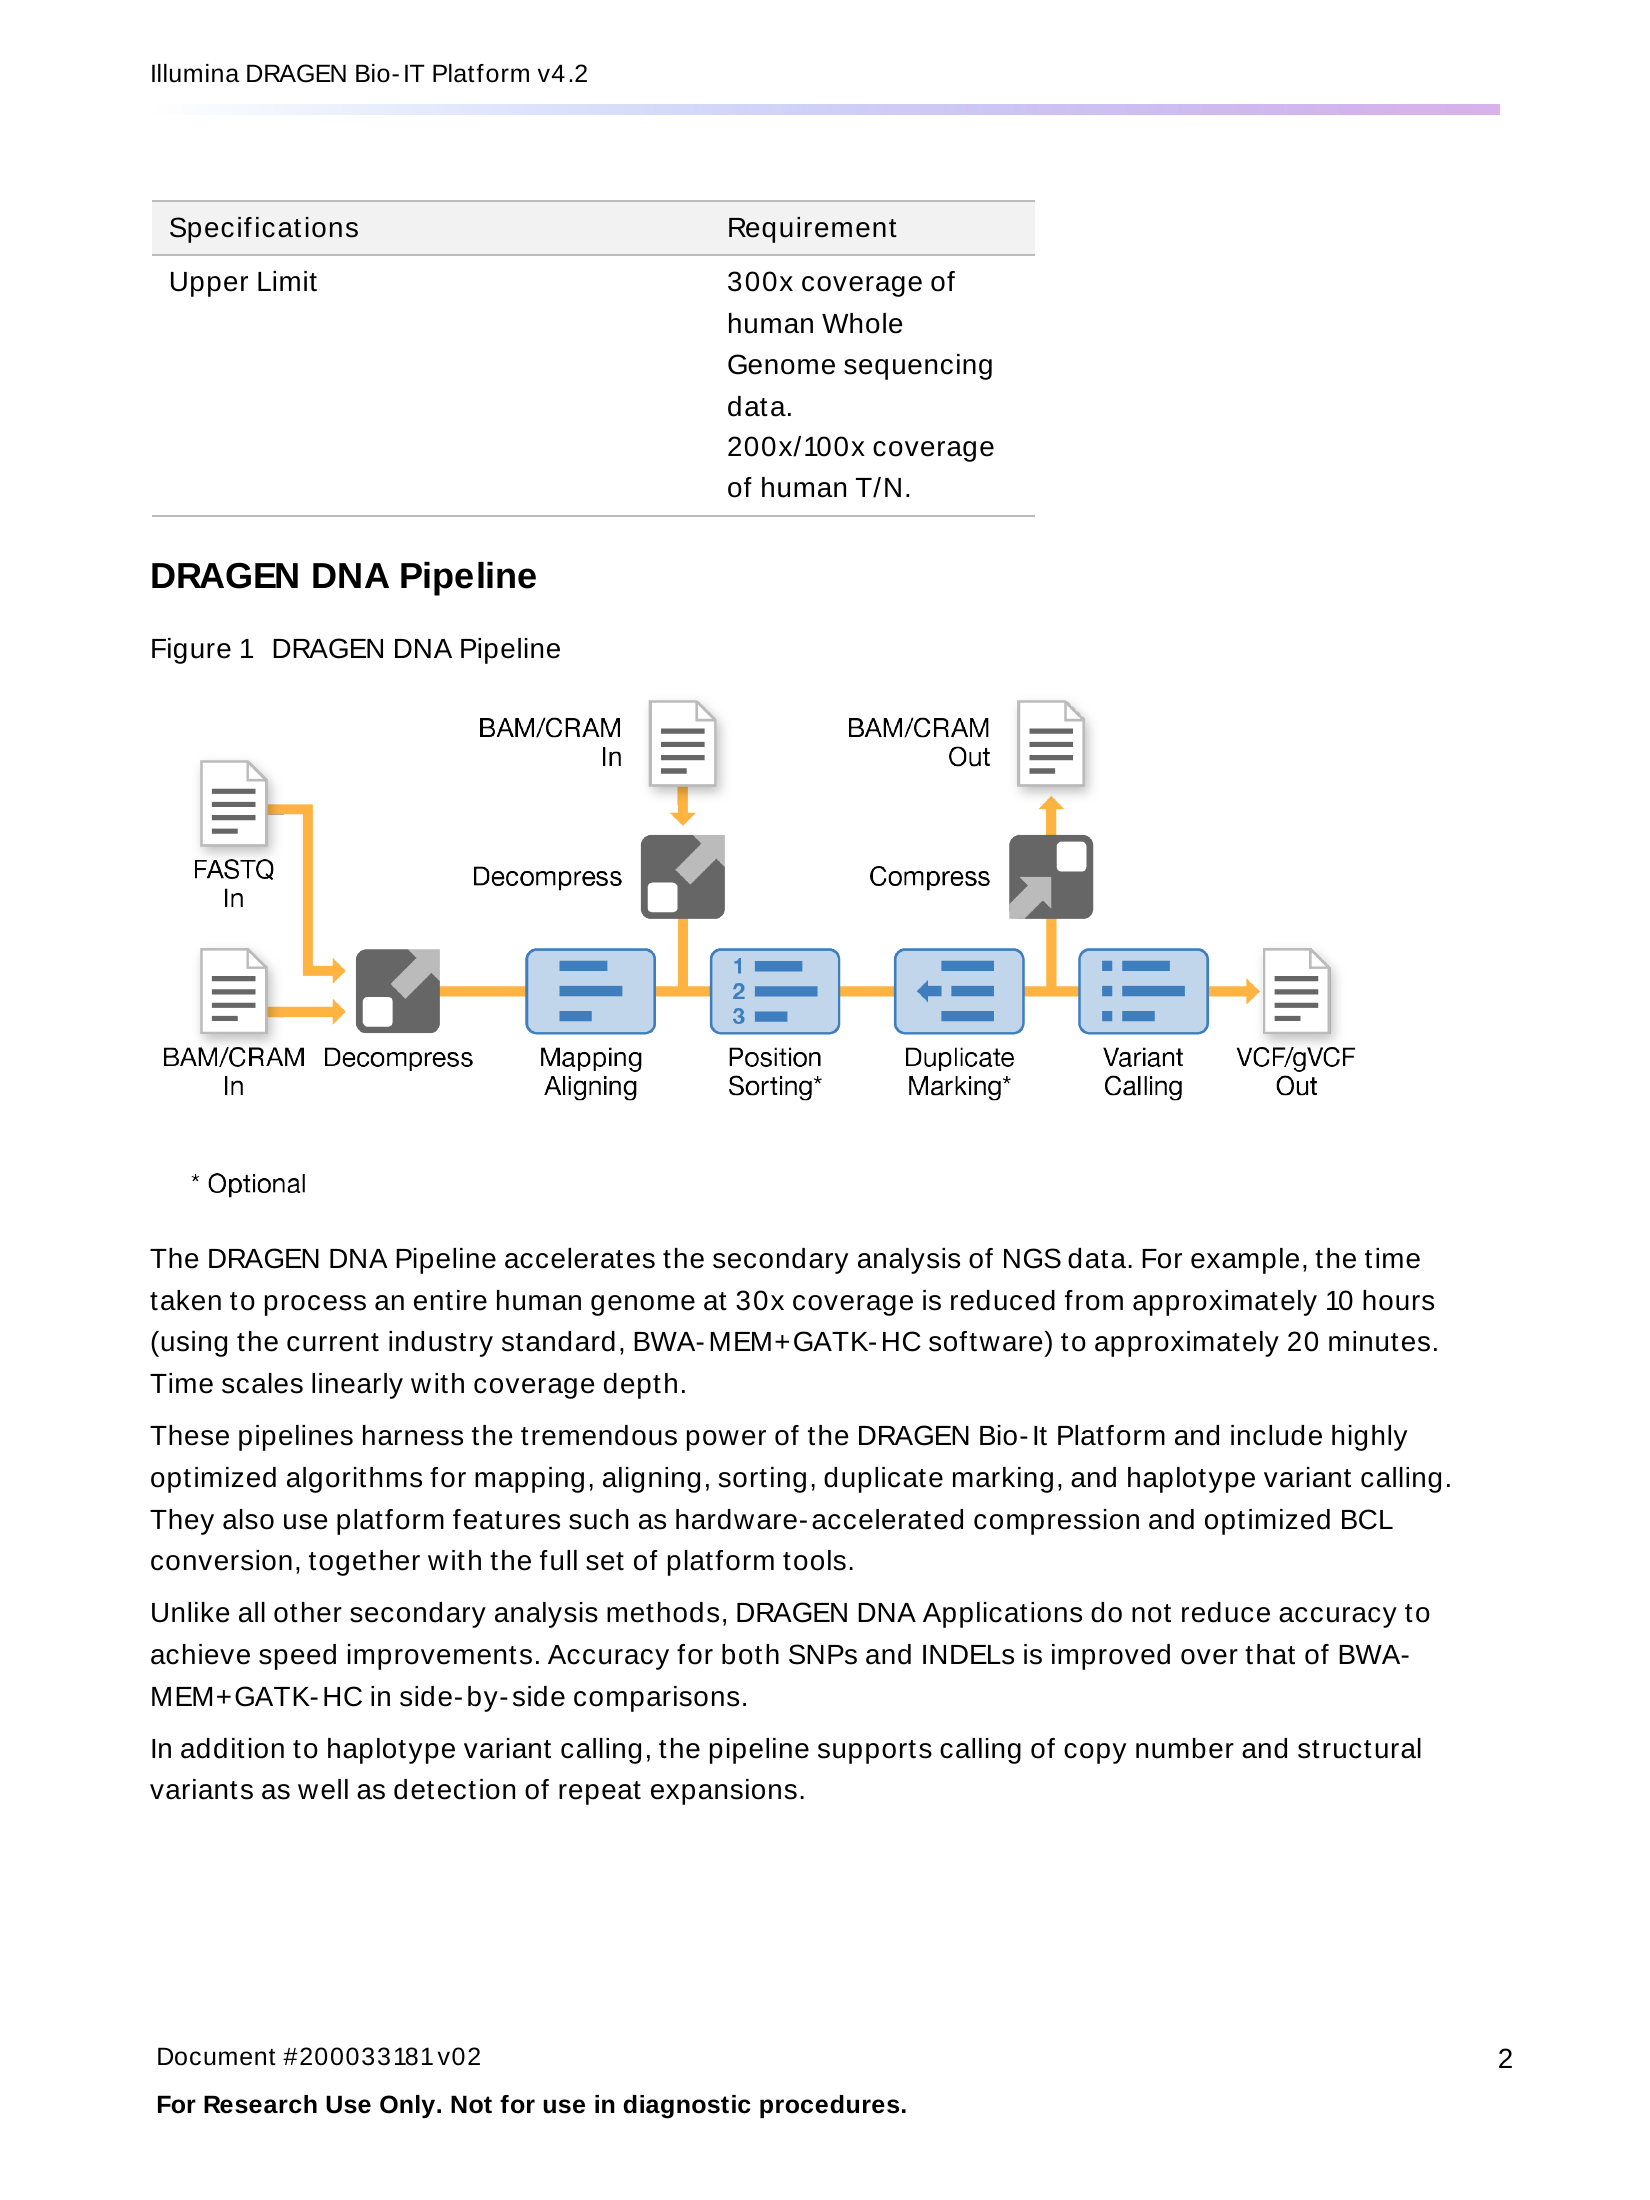

In [7]:
# test
file_path = "files/page_007.pdf"
images = convert_doc_to_images(file_path)
text = extract_text_from_doc(file_path)
for img in images:
    display(img)

In [8]:
# Image analysis with GPT-4o
import os
import openai
with open("oai_token.txt", 'r') as file:
    os.environ["OPENAI_API_KEY"] = file.readline().strip()
openai.api_key = os.environ["OPENAI_API_KEY"]
client = OpenAI()

In [9]:
# Intermediate step to process the information to then chunk it. 

system_prompt = '''
You will be provided with an image of a PDF page. Your goal is to deliver a detailed and precise presentation about the content you see, prioritizing accuracy.

If there is an identifiable title, start by stating the title to provide context for your audience.

Describe visual elements in detail:

- **Diagrams**: Explain each component and how they interact. For example, "The process begins with X, which then leads to Y and results in Z."
  
- **Tables**: Break down the information logically. For instance, "Product A costs X dollars, while Product B is priced at Y dollars."

- **Code**: Explain the purpose of any commands or command line flags presented in detail.

Focus on the content itself rather than the format:

- **DO NOT** include terms referring to the content format.
  
- **DO NOT** mention the content type. Instead, directly discuss the information presented.

Keep your explanation comprehensive:

- Be exhaustive in describing the content, as your audience cannot see the image.

Be helpful but stick to the content:

- Complement your response with the current page number.

Engage with the content:

- Interpret and analyze the information where appropriate, offering insights to help the audience understand its significance. However, stick to the content and do not invent content.

'''

# Converting images to base64 encoded images in a data URI format to use with the ChatCompletions API
def get_img_uri(img):
    png_buffer = io.BytesIO()
    img.save(png_buffer, format="PNG")
    png_buffer.seek(0)

    base64_png = base64.b64encode(png_buffer.read()).decode('utf-8')

    data_uri = f"data:image/png;base64,{base64_png}"
    return data_uri

def analyze_image(data_uri):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": [
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{data_uri}"
                    }
                    }
                ]
                },
        ],
        max_tokens=500,
        temperature=0,
        top_p=0.1
    )
    return response.choices[0].message.content

In [10]:
# test
img = images[0]
display(img)
data_uri = get_img_uri(img)
res = analyze_image(data_uri)
print(res)

NameError: name 'images' is not defined

In [11]:
# Processing all documents (NOTE: UNORDERED)
files_path = "files"

all_items = os.listdir(files_path)
files = [item for item in all_items if os.path.isfile(os.path.join(files_path, item)) and not item.endswith(".json") and not item == "4-2_manual.pdf"]
files = sorted(files)
# remove non-content pages
del(files[0:6])
del(files[-1])
#print(files)

In [12]:
import json

def analyze_doc_image(img):
    img_uri = get_img_uri(img)
    data = analyze_image(img_uri)
    return data

def analyze_all():
    docs = []
    
    # file will be created if it doesn't exist
    with open("files/RAG_raw_data.json", "a+") as raw_data:
        raw_data.seek(0) # read from the beginning
        try:
            docs = json.load(raw_data)
            i = len(docs)
        # empty file
        except json.JSONDecodeError: 
            pass

    start = len(docs) # next index to be processed
    for i in range(start, len(files)):
        f = files[i]
        path = f"{files_path}/{f}"
        doc = {
            "filename": f
        }
        text = extract_text_from_doc(path)
        doc['text'] = text
        imgs = convert_doc_to_images(path)
        pages_description = []
        
        #print(f"Analyzing pages for doc {f}")
        
        # Concurrent execution
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            
            futures = [
                executor.submit(analyze_doc_image, img)
                for img in imgs
            ]
            
            #with tqdm(total=len(imgs)-1) as pbar:
            #    for _ in concurrent.futures.as_completed(futures):
            #        pbar.update(1)
            
            for f in futures:
                res = f.result()
                pages_description.append(res)
            
        doc['pages_description'] = pages_description
        docs.append(doc)

        if (i + 1) % 10 == 0 or i == len(files) - 1:
            with open("files/RAG_raw_data.json", "w") as raw_data:
                json.dump(docs, raw_data, indent=2)

In [13]:
analyze_all()

In [14]:
with open("files/RAG_raw_data.json", 'r') as f:
    docs = json.load(f)

In [15]:
# Chunk the content
# Chunking content by page and merging together text & description if applicable
content = []
for doc in docs:
    text = doc['text'].split('\f')
    description = doc['pages_description']
    description_indexes = []
    for i in range(len(text)):
        slide_content = text[i] + '\n'
        # Trying to find matching slide description
        slide_title = text[i].split('\n')[0]
        for j in range(len(description)):
            description_title = description[j].split('\n')[0]
            if slide_title.lower() == description_title.lower():
                slide_content += description[j].replace(description_title, '')
                # Keeping track of the descriptions added
                description_indexes.append(j)
        # Adding the slide content + matching slide description to the content pieces
        content.append(slide_content) 
    # Adding the slides descriptions that weren't used
    for j in range(len(description)):
        if j not in description_indexes:
            content.append(description[j])

In [16]:
#for c in content:
#    print(c)
#    print("\n\n-------------------------------\n\n")

In [17]:
# Cleaning up content
# Removing trailing spaces, additional line breaks, page numbers and references to the content being a slide
clean_content = []
for c in content:
    text = c.replace(' \n', '').replace('\n\n', '\n').replace('\n\n\n', '\n').strip()
    text = re.sub(r"(?<=\n)\d{1,2}", "", text)
    text = re.sub(r"\b(?:the|this)\s*slide\s*\w+\b", "", text, flags=re.IGNORECASE)
    clean_content.append(text)

In [22]:
# Creating the embeddings
# We'll save to a csv file here for testing purposes but this is where you should load content in your vectorDB.
df = pd.DataFrame(clean_content, columns=['content'])
print(df.shape)
df.head()

(2199, 1)

,content
0,Illumina DRAGEN Bio- IT Platform v4.2\nGetting...
1,
2,"### Getting Started\nBefore beginning, ensure ..."
3,Illumina DRAGEN Bio- IT Platform v4.2\nSpecifi...
4,


In [18]:
embeddings_model = "text-embedding-3-large"

def get_embeddings(text):
    embeddings = client.embeddings.create(
      model="text-embedding-3-small",
      input=text,
      encoding_format="float"
    )
    return embeddings.data[0].embedding

In [24]:
df['embeddings'] = df['content'].apply(lambda x: get_embeddings(x))
df.head()

,content,embeddings
0,Illumina DRAGEN Bio- IT Platform v4.2\nGetting...,"[-0.027298287, 0.029518396, 0.034275774, -0.02..."
1,,"[0.015368387, -0.034810703, -0.009328825, 0.01..."
2,"### Getting Started\nBefore beginning, ensure ...","[-0.022800766, 0.034109212, 0.05888666, -0.022..."
3,Illumina DRAGEN Bio- IT Platform v4.2\nSpecifi...,"[-0.011220413, 0.027055155, 0.06041851, 0.0013..."
4,,"[0.015368387, -0.034810703, -0.009328825, 0.01..."


In [19]:
data_path = "RAG-openai-data/parsed_pdf_docs_with_embeddings.csv"

In [26]:
# Saving locally for later
df.to_csv(data_path, index=False)

In [20]:
# Optional: load data from saved file
df = pd.read_csv(data_path)
df["embeddings"] = df.embeddings.apply(literal_eval).apply(np.array)

In [21]:
# RAG
system_prompt = '''
    You will be provided with an input prompt and content as context that can be used to reply to the prompt.
    
    You will do 2 things:
    
    1. First, you will internally assess whether the content provided is relevant to reply to the input prompt. 
    
    2a. If that is the case, answer directly using this content. If the content is relevant, use elements found in the content to craft a reply to the input prompt.

    2b. If the content is not relevant, use your own knowledge to reply when the question is non-technical or say that you don't know how to respond if your knowledge is not sufficient to answer.
    
    Stay concise with your answer, replying specifically to the input prompt without mentioning additional information provided in the context content.
'''

model="gpt-4o"

def search_content(df, input_text, top_k):
    embedded_value = get_embeddings(input_text)
    df["similarity"] = df.embeddings.apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    res = df.sort_values('similarity', ascending=False).head(top_k)
    return res

def get_similarity(row):
    similarity_score = row['similarity']
    if isinstance(similarity_score, np.ndarray):
        similarity_score = similarity_score[0][0]
    return similarity_score

def generate_output(input_prompt, similar_content, threshold = 0.5):
    
    content = similar_content.iloc[0]['content']
    
    # Adding more matching content if the similarity is above threshold
    if len(similar_content) > 1:
        for i, row in similar_content.iterrows():
            similarity_score = get_similarity(row)
            if similarity_score > threshold:
                content += f"\n\n{row['content']}"
            
    prompt = f"INPUT PROMPT:\n{input_prompt}\n-------\nCONTENT:\n{content}"
    
    completion = client.chat.completions.create(
        model=model,
        temperature=0.5,
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": prompt
            }
        ]
    )

    return completion.choices[0].message.content
    

In [22]:
# Example user queries related to the content
example_inputs = [
    'If the DRAGEN software is run with the parameter --enable-variant-caller=true, what are the implications? Construct a command line including this parameter',
    'Using the Illumina DRAGEN software, how do you construct a command line for mapping FASTQ files to a reference genome?',
    'Provide an example using the reference genome GRCh38 and input files sample1_R1.fastq and sample1_R2.fastq',
    'What is the command line syntax to enable variant calling in DRAGEN?',
    'Include parameters for setting the output directory to /data/output and specifying a memory limit of 16 GB.',
    'Write a command line to perform mapping, variant calling, and generate a BAM file, using DRAGEN. Include the input files reads_R1.fastq and reads_R2.fastq, a reference genome hg19, and an output directory /output_dir',
    'The following command results in an error: dragen --input sample.fastq --output-dir /output. Correct the command and explain the changes you made.',
]

In [23]:
# Running the RAG pipeline on each example
for ex in example_inputs:
    print(f"[deep_pink4][bold]QUERY:[/bold] {ex}[/deep_pink4]\n\n")
    matching_content = search_content(df, ex, 3)
    print(f"[grey37][b]Matching content:[/b][/grey37]\n")
    for i, match in matching_content.iterrows():
        print(f"[grey37][i]Similarity: {get_similarity(match):.2f}[/i][/grey37]")
        print(f"[grey37]{match['content'][:100]}{'...' if len(match['content']) > 100 else ''}[/[grey37]]\n\n")
    reply = generate_output(ex, matching_content)
    print(f"[turquoise4][b]REPLY:[/b][/turquoise4]\n\n[spring_green4]{reply}[/spring_green4]\n\n--------------\n\n")

QUERY: If the DRAGEN software is run with the parameter --enable-variant-caller=true, what are the implications? 
Construct a command line including this parameter

Matching content:

Similarity: 0.69

Illumina DRAGEN Bio- IT Platform v4.2
Example Command Line
For most scenarios, creating the union of...[/]

Similarity: 0.67

Illumina DRAGEN Bio- IT Platform v4.2
  --enable-sort true \
"
UMI_OPTIONS="
  --enable-umi true \
 ...[/]

Similarity: 0.66

Illumina DRAGEN Bio- IT Platform v4.2
License Options
To suppress the license status message at the ...[/]

REPLY:

Running the DRAGEN software with the parameter `--enable-variant-caller=true` enables the variant caller 
functionality. This means that DRAGEN will perform variant calling to produce a VCF file, either as part of a full 
pipeline process or in a standalone mode if mapping and aligning have already been completed. Here is an example 
command line including this parameter:

```bash
dragen \
  --enable-variant-caller=true \
  --ref-dir <REF_DIR> \
  --output-dir <OUT_DIR> \
  --output-file-prefix <OUT_PREFIX> \
  --target-bed <MANIFEST.bed> \
  --input-file <INPUT_FILE> \
  --enable-sort=true
```

Make sure to replace `<REF_DIR>`, `<OUT_DIR>`, `<OUT_PREFIX>`, `<MANIFEST.bed>`, and `<INPUT_FILE>` with your 
specific paths and filenames.

--------------

QUERY: Using the Illumina DRAGEN software, how do you construct a command line for mapping FASTQ files to a 
reference genome?

Matching content:

Similarity: 0.76

Illumina DRAGEN Bio- IT Platform v4.2
DRAGEN Host Software
You use the DRAGEN host software program ...[/]

Similarity: 0.76

The document provides example command lines for mapping and aligning different types of genomic data...[/]

Similarity: 0.76

Illumina DRAGEN Bio- IT Platform v4.2
Prepare a Reference Genome
Before a reference genome can be us...[/]

REPLY:

To construct a command line for mapping FASTQ files to a reference genome using Illumina DRAGEN software, you can 
use the following command:

```bash
dragen -r <REF_DIRECTORY> --output-directory <OUT_DIRECTORY> \
--output-file-prefix <FILE_PREFIX> -1 <FASTQ1> [-2 <FASTQ2>] \
--RGID <RG0> --RGSM <SM0> --enable-map-align true
```

Replace `<REF_DIRECTORY>` with the path to your reference genome directory, `<OUT_DIRECTORY>` with your desired 
output directory, `<FILE_PREFIX>` with your chosen output file prefix, `<FASTQ1>` with your first FASTQ file, 
`<FASTQ2>` with your second FASTQ file if applicable, `<RG0>` with the read group ID, and `<SM0>` with the sample 
name.

--------------

QUERY: Provide an example using the reference genome GRCh38 and input files sample1_R1.fastq and sample1_R2.fastq

Matching content:

Similarity: 0.60

**Inputs**
**Set of population VCF**
The custom multigenome hash table builder tool requires a set o...[/]

Similarity: 0.58

Illumina DRAGEN Bio- IT Platform v4.2
--output-file-prefix SRA056922_30x_e10_50M \
--enable-duplicat...[/]

Similarity: 0.58

**Prepare a Reference Genome**
Before using a reference genome with DRAGEN, it must be converted fro...[/]

REPLY:

To process the input files `sample1_R1.fastq` and `sample1_R2.fastq` using the reference genome GRCh38, you can use
a command similar to the following with a tool like DRAGEN:

```bash
dragen -f \
-r /path/to/reference/GRCh38/GRCh38.fa \
-1 /path/to/data/sample1_R1.fastq \
-2 /path/to/data/sample1_R2.fastq \
--enable-variant-caller true \
--output-directory /path/to/output/ \
--output-file-prefix sample1_output \
--enable-duplicate-marking true \
--enable-map-align-output true \
--output-format BAM
```

Make sure to replace `/path/to/reference/GRCh38/GRCh38.fa` with the actual path to your GRCh38 reference file, and 
`/path/to/data/` and `/path/to/output/` with the correct paths for your input files and desired output directory.

--------------

QUERY: What is the command line syntax to enable variant calling in DRAGEN?

Matching content:

Similarity: 0.71

Illumina DRAGEN Bio- IT Platform v4.2
  --enable-sort true \
"
UMI_OPTIONS="
  --enable-umi true \
 ...[/]

Similarity: 0.70

Illumina DRAGEN Bio- IT Platform v4.2
Example Command Line
For most scenarios, creating the union of...[/]

Similarity: 0.69

**The Variant Caller Algorithm**
The DRAGEN Small Variant Caller performs several key steps:
. **Act...[/]

REPLY:

To enable variant calling in DRAGEN, use the command line option `--enable-variant-caller true`.

--------------

QUERY: Include parameters for setting the output directory to /data/output and specifying a memory limit of 16 GB.

Matching content:

Similarity: 0.46

Illumina DRAGEN Bio- IT Platform v4.2
# Path to output directory for the DRAGEN run
OUTPUT=<OUT_DIR>...[/]

Similarity: 0.45

Illumina DRAGEN Bio- IT Platform v4.2
# Path to output directory for the DRAGEN run
OUTPUT=<OUT_DIR>...[/]

Similarity: 0.45

Illumina DRAGEN Bio- IT Platform v4.2
OUTPUT_OPTIONS="
  --output-directory $OUTPUT \
  --output-fil...[/]

REPLY:

To set the output directory to `/data/output` and specify a memory limit of 16 GB, you can modify the parameters as
follows:

```bash
OUTPUT="/data/output"
MEMORY_LIMIT="16GB"
```

These parameters should be integrated into the configuration or command line options of the software or script you 
are using.

--------------

QUERY: Write a command line to perform mapping, variant calling, and generate a BAM file, using DRAGEN. Include the
input files reads_R1.fastq and reads_R2.fastq, a reference genome hg19, and an output directory /output_dir

Matching content:

Similarity: 0.77

Illumina DRAGEN Bio- IT Platform v4.2
--output-file-prefix SRA056922_PE_30x_rand1_10K_interleaved \
...[/]

Similarity: 0.75

The document provides example command lines for mapping and aligning different types of genomic data...[/]

Similarity: 0.75

Illumina DRAGEN Bio- IT Platform v4.2
Generate an Alignment File
The following command- line example...[/]

REPLY:

The content provided is not directly relevant to the specific task of mapping, variant calling, and generating a 
BAM file using DRAGEN with the specified inputs. However, based on general knowledge of DRAGEN commands, here is a 
command line that can be used:

```bash
dragen \
-r /path/to/hg19_hash_table \
-1 reads_R1.fastq \
-2 reads_R2.fastq \
--output-directory /output_dir \
--output-file-prefix output_prefix \
--enable-map-align true \
--enable-variant-caller true \
--output-format BAM
```

Make sure to replace `/path/to/hg19_hash_table` with the actual path to the hg19 reference hash table. Adjust 
additional parameters as needed for your specific setup.

--------------

QUERY: The following command results in an error: dragen --input sample.fastq --output-dir /output. Correct the 
command and explain the changes you made.

Matching content:

Similarity: 0.61

Illumina DRAGEN Bio- IT Platform v4.2
set -euo pipefail
# Path to DRAGEN hashtable
DRAGEN_HASH_TABLE...[/]

Similarity: 0.61

Illumina DRAGEN Bio- IT Platform v4.2
#!/bin/bash
set -euo pipefail
# Path to DRAGEN hashtable
DRAGE...[/]

Similarity: 0.60

Illumina DRAGEN Bio- IT Platform v4.2
This message is followed by a block of metrics such as read co...[/]

REPLY:

The content provided is not directly relevant to correcting the command. However, based on general knowledge of the
DRAGEN command, the issue might be related to the absence of necessary options for specifying input file types or 
other required parameters. Here is a corrected version of the command with an explanation:

Corrected Command:
```
dragen -f --fastq-file1 sample.fastq --output-directory /output
```

Explanation:
- Added `-f` to force overwrite of output files if they exist.
- Replaced `--input` with `--fastq-file1` to specify the input FASTQ file correctly.
- Changed `--output-dir` to `--output-directory` to match the correct option name.
  
Ensure that any other necessary parameters (e.g., reference genome, additional input files) are included as 
required for your specific analysis.

--------------